In [39]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                             recall_score, roc_auc_score, mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
import xgboost as xgb
import math
import shap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

from  config_smartphone import smartphone_set1


In [119]:

path1 ='/Users/jerzybala/Desktop/BrainBaseMHQ/MHQ_raw_Jan2023_to_Feb2024_processed.csv'

df = pd.read_csv(path1, low_memory=False)

df.shape

(599595, 104)

In [43]:
df.columns.to_list()

data_org = df[smartphone_set1]

In [67]:
# Remove rows where 'Smartphone ownership' column matches the specific value
data_org = data_org[data_org['Smartphone ownership'] != 'எனக்கு ஸ்மார்ட்போன் சொந்தமா இல்ல']

values_to_remove = [
    'ஒரு சில வருஷத்துக்கு பின்னாடி', # Tamil for 'A few years later'
    'ஒரு சில மாசத்துக்கு பின்னாடி', # Tamil for 'A few months later'
    'ஒரே சமயத்துல', # Tamil for 'At the same time'
    'כמה חודשים לפני כן', # Hebrew for 'A few months before'
    'Più o meno nello stesso periodo', # Italian for 'Around the same time'
    'ஒரு சில வருஷத்துக்கு முன்னாடி', # Tamil for 'A few years before'
    'Qualche mese dopo', # Italian for 'A few months after'
    'Qualche anno prima' # Italian for 'A few years before'
]

# Remove rows where 'Friends/classmates smartphone ownership' column matches any of the specified values
data_org = data_org[~data_org['Friends/classmates smartphone ownership'].isin(values_to_remove)]

data_org = data_org[data_org['Age of smartphone usage during school hours'] != "Non l'ho mai portato a scuola"]

data_org = data_org[data_org['Smartphone usage during class hours'] != "एक दिन में थोड़ी बार"]
data_org = data_org[data_org['Smartphone usage during class hours'] != "Raramente in un giorno"]




In [70]:
#data_org['Smartphone ownership'].unique()
#data_org['Friends/classmates smartphone ownership'].unique()
#data_org['Age of smartphone usage during school hours'].unique()
data_org['Smartphone usage during class hours'].unique()


array(['Never', nan, 'A few times in a day', 'Many times in a day',
       'Rarely in a day', 'Several times a day'], dtype=object)

In [106]:
data_org.shape

#Use dropna to remove rows where any of the specified columns have NaN values
# The subset parameter allows specifying columns where NaNs will lead to row deletion
data_org_1 = data_org.dropna(subset=smartphone_columns)

# Further filter out rows with empty strings in any of the specified columns
for column in smartphone_columns:
    data_org_1 = data_org_1[data_org_1[column] != '']


data_org_1.shape

data_org_1.to_csv('/Users/jerzybala/Desktop/BrainBaseMHQ/MHQ_raw_Jan2023_to_Feb2024_processed_1.csv', index=False)


In [107]:
data_org_1.columns.to_list()

data_org_1= data_org_1.drop(columns=['City','Ethnicity','Country','State','Household Income','Current Family Situation'])

In [111]:

# Assuming data_org_1 is your DataFrame
# Let's first identify categorical columns. This is a simplification; you might need a more nuanced approach.
categorical_cols = data_org_1.select_dtypes(include=['object', 'category']).columns

# Now, let's exclude binary categorical columns from this list
non_binary_categorical_cols = [col for col in categorical_cols if len(data_org_1[col].unique()) > 2]

# Apply One-Hot Encoding only to non-binary categorical columns
# get_dummies will automatically skip non-categorical columns
data_org_1_encoded = pd.get_dummies(data_org_1, columns=non_binary_categorical_cols, drop_first=False)

# The resulting DataFrame, data_org_1_encoded, now has One-Hot Encoded features for non-binary categorical columns
data_org_1_encoded.columns.to_list()

data_org_1_encoded.to_csv('/Users/jerzybala/Desktop/BrainBaseMHQ/MHQ_raw_Jan2023_to_Feb2024_processed_1_encoded.csv', index=False)

In [73]:
smartphone_columns = [
    'Smartphone ownership',
    'Friends/classmates smartphone ownership',
    'Age of smartphone usage during school hours',
    'Smartphone usage during class hours',
    'Smartphone usage during break'
]

# Assuming 'data' is your DataFrame


# Create a mask where True indicates rows where all specified columns are not empty
mask = data_org[smartphone_columns].notna().all(axis=1)

# Apply the mask to the original DataFrame to filter rows while keeping all columns
smartphone_data = data_org[mask]

# Get the number of such records
number_of_records = len(smartphone_data)
print(f"Number of records where the specified columns are not empty: {number_of_records}")



Number of records where the specified columns are not empty: 46787


## Entropy Calculation

In [15]:
import numpy as np
from scipy.stats import entropy

def calculate_infogain(df, target):
    # Calculate the entropy of the target variable
    target_entropy = entropy(df[target].value_counts(normalize=True), base=2)
    
    # Calculate the entropy of each feature
    feature_entropies = []
    for column in df.columns:
        if column != target:
            feature_entropy = 0
            for value in df[column].unique():
                subset = df[df[column] == value]
                subset_entropy = entropy(subset[target].value_counts(normalize=True), base=2)
                feature_entropy += (len(subset) / len(df)) * subset_entropy
            feature_entropies.append(feature_entropy)
    
    # Calculate the information gain for each feature
    infogains = target_entropy - np.array(feature_entropies)
    
    # Create a dictionary mapping each feature to its information gain
    infogain_dict = dict(zip(df.columns[df.columns != target], infogains))
    
    return infogain_dict



smartphone_INFOGAIN_columns = [
    'Smartphone ownership',
    'Friends/classmates smartphone ownership',
    'Age of smartphone usage during school hours',
    'Smartphone usage during class hours',
    'Smartphone usage during break',
    'MHQ_Sign'
]

data_SIG = data_org[smartphone_INFOGAIN_columns]
info_gained_SP_features = calculate_infogain(data_SIG, 'MHQ_Sign')

data_SIG.to_csv('/Users/jerzybala/Desktop/BrainBaseMHQ/data_SIG.csv', index=False)    

In [117]:

data_org_1_encoded_MHQ = data_org_1_encoded.drop(columns=['Overall MHQ'])  


IG_data_org_1_encoded_MHQ = calculate_infogain(data_org_1_encoded_MHQ, 'MHQ_Sign')




In [77]:
data_SIG = data_org[smartphone_INFOGAIN_columns]

data_SIG_1 = data_SIG[mask]

info_gained_SP_features_1 = calculate_infogain(data_SIG_1, 'MHQ_Sign')

data_SIG_1.to_csv('/Users/jerzybala/Desktop/BrainBaseMHQ/data_SIG_1.csv', index=False)    

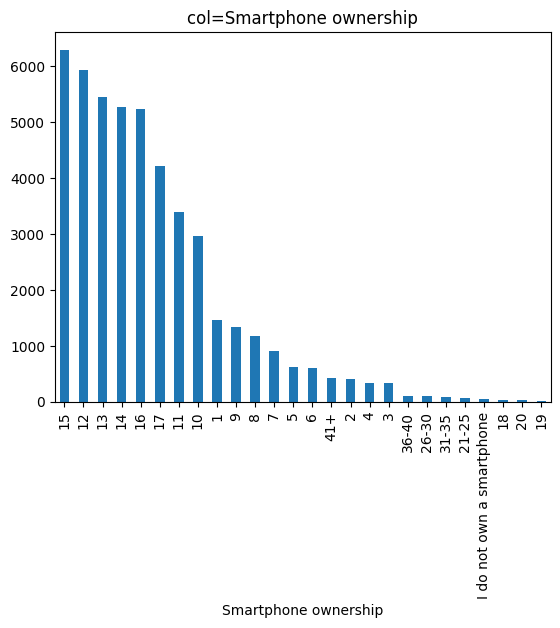

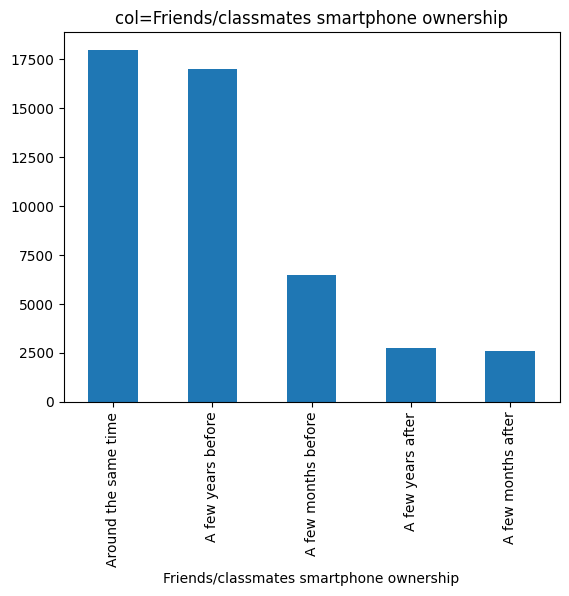

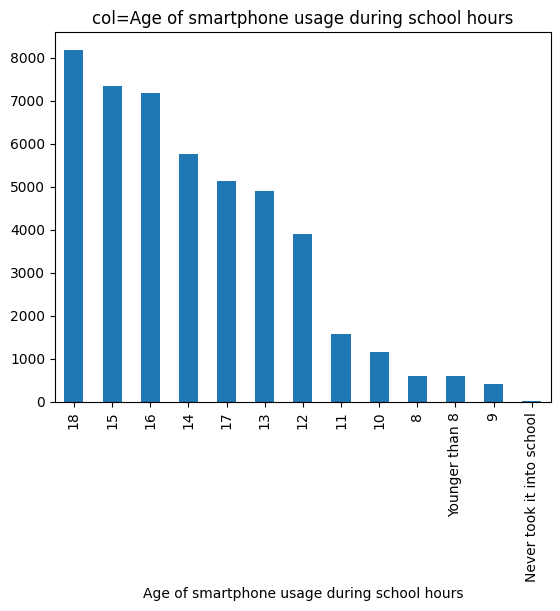

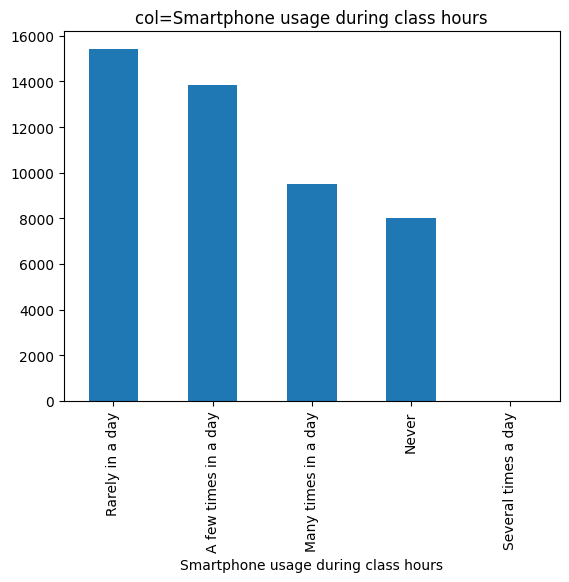

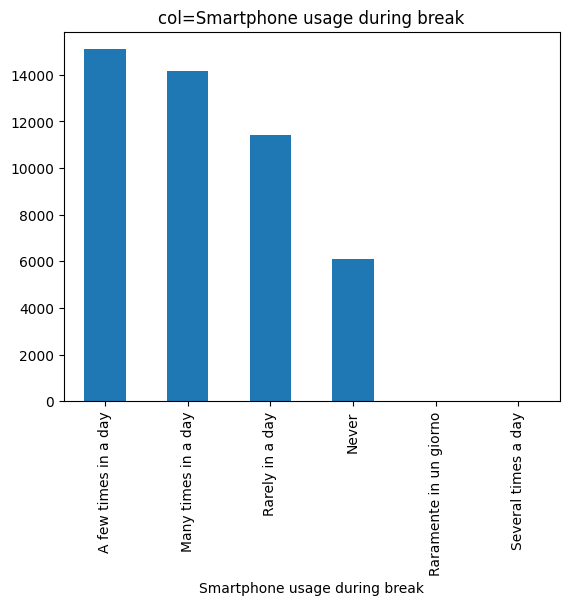

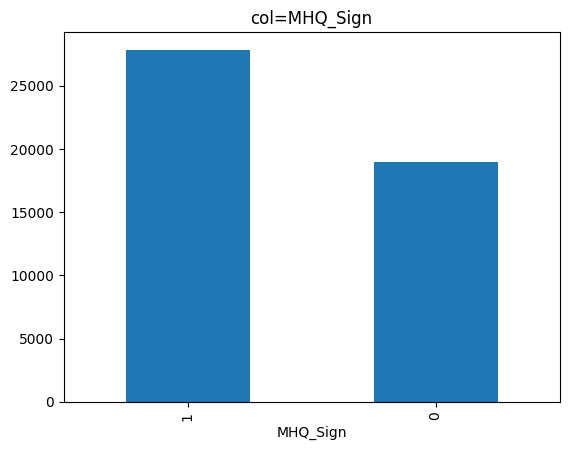

In [75]:
for col in smartphone_INFOGAIN_columns:
    data_SIG_1[col].value_counts().plot(kind='bar', title=f'col={col}')
    plt.show()
    



In [16]:
from tabulate import tabulate

def print_sorted_feature_scores(feature_scores, score_name="Score", table_format="grid"):
    """
    Sorts a dictionary of features and their scores in descending order and prints it in tabulated format.

    Parameters:
    - feature_scores: Dictionary with features as keys and scores as values.
    - score_name: A string representing the name of the score for the header. Defaults to "Score".
    - table_format: A string representing the table format to be used by tabulate. Defaults to "grid".
    """
    # Convert the dictionary to a list of tuples and sort it in descending order by score
    feature_scores_sorted = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Print the sorted list in tabulate format with customizable headers
    print(tabulate(feature_scores_sorted, headers=["Feature", score_name], tablefmt=table_format))



In [ ]:
columns_to_drop = ['Language', 'Start Date (UTC)', 'Submit Date (UTC)', 'Time to completion']
data2 = data_org.drop(columns=columns_to_drop, inplace=True)


In [118]:
# Example usage for information gain:
print_sorted_feature_scores(IG_data_org_1_encoded_MHQ, score_name="Information Gain")

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
| Feature                                                                                                                                                                                            |   Information Gain |
+====================================================================================================================================================================================================+====================+
| Prolonged emotional or psychological abuse or neglect from parent/caregiver                                                                                                                        |        0.034643    |
+-----------------------------------------------------------------------------------------------------------------------

In [18]:

print_sorted_feature_scores(info_gained_all_features, score_name="Information Gain")

+---------------------------------------------------------------------------------------+--------------------+
| Feature                                                                               |   Information Gain |
+=======================================================================================+====================+
| Overall MHQ                                                                           |        0.81309     |
+---------------------------------------------------------------------------------------+--------------------+
| Laptop usage for non-learning activities                                              |        0.738446    |
+---------------------------------------------------------------------------------------+--------------------+
| City                                                                                  |        0.736197    |
+---------------------------------------------------------------------------------------+--------------------+
|

In [19]:
data_org.to_csv('/Users/jerzybala/Desktop/BrainBaseMHQ/MHQ_raw_Jan2023_to_Feb2024_processed.csv', index=False)

In [24]:
import pandas as pd

# Assuming data_org is your DataFrame

cat_columns = [
 'Smartphone ownership',
 'Friends/classmates smartphone ownership',
 'Age of smartphone usage during school hours',
 'Smartphone usage during class hours',
 'Smartphone usage during break',
 'Age of first social media account',
 'Frequency of social media posting',
 'Tablet ownership',
 'Age of laptop usage required by school',
 'Laptop usage for non-learning activities'
 ]


data_org_encoded = pd.get_dummies(data_org, columns = cat_columns, drop_first=True)



In [22]:
#data_org_encoded.columns.to_list()


In [25]:
info_gained_data_org_encoded = calculate_infogain(data_org_encoded, 'MHQ_Sign')
# Example usage for information gain:
print_sorted_feature_scores(info_gained_data_org_encoded, score_name="Information Gain")

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
| Feature                                                                                                                                                                                                                               |   Information Gain |
+=======================================================================================================================================================================================================================================+====================+
| Overall MHQ                                                                                                                                                                                                                           |  

In [26]:
data_org_encoded.to_csv('/Users/jerzybala/Desktop/temp.csv', index=False)  

In [ ]:

par1 = {
    'n_estimators': 200, 
    'learning_rate': 0.01,
    'max_depth': 10, 
    'min_child_weight': 1, 
    'gamma': 0.01, 
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Initialize XGBoost classifier and train

model_C = xgb.XGBClassifier(**par1)
model_C.fit(X_train, y_train)